# Clean Pipeline - Предсказание alpha канала

**Задача**: Предсказание alpha (0..255), метрика MSE

**Данные**: MAGICK (train), Kaggle test (orig_1024)

## 1. Imports

In [14]:
import os
import io
import sys
import base64
import random
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
import scipy.ndimage

Image.MAX_IMAGE_PIXELS = None

## 2. CONFIG

In [15]:
Image.MAX_IMAGE_PIXELS = None

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision("high")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# пути
TRAIN_CSV = Path("data/splits/train.csv")
VAL_CSV   = Path("data/splits/val.csv")
TEST_ROOT = Path("data/test_dataset/orig_1024")
MODEL_DIR = Path("outputs/experiments/exp_001")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_SIZE = (512, 512)
VAL_SIZE   = (1024, 1024)
TRAIN_BATCH = 4
VAL_BATCH   = 1

LIMIT_DATA = 10
   
NUM_EPOCHS = 1
LR = 1e-4
RUN_TRAINING = True

## 3. Dataset + Transforms

In [16]:
# Airport X-ray Alpha аугментация - детализированная версия с внутренним "объёмом"
# Использует volume (CLAHE) + structure (multi-scale DoG) с деталями как модулятором

import cv2

def xray_alpha_dense(rgb_u8, alpha01,
                   obj_floor_range=(0.10, 0.25),
                   k_range=(0.35, 0.70),
                   w_volume=0.60, w_struct=0.40,
                   struct_mod=0.30,
                   clahe_clip=2.0, clahe_grid=16,
                   dog_scales=(1.0, 2.0, 4.0, 8.0),
                   grad_w=0.15,
                   blur_after=1.2):
    """
    X-ray Alpha аугментация с внутренним "объёмом" без облаков.
    
    ИСПРАВЛЕНО согласно проблемам 2-4:
    - Multi-scale DoG (1-2-4-8) + grad для структуры (средние частоты без шума)
    - Volume компонента (1 - CLAHE(luma)) для объёмной плотности
    - Детали как модулятор: density = clamp(volume * (1 - struct_mod*struct), floor, 1)
    
    rgb_u8: HxWx3 uint8
    alpha01: HxW float32 [0..1]
    
    Возвращает: HxW float32 [0..1]
    """
    eps = 1e-6
    a = alpha01.astype(np.float32)
    obj = (a > 0.01).astype(np.float32)

    rgb = rgb_u8.astype(np.float32) / 255.0
    luma = 0.299*rgb[...,0] + 0.587*rgb[...,1] + 0.114*rgb[...,2]  # 0..1

    # --- (A) volume: CLAHE + invert (локальная выровненная инверсия яркости) ---
    l8 = np.clip(luma*255.0, 0, 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(clahe_grid, clahe_grid))
    l_eq = clahe.apply(l8).astype(np.float32) / 255.0
    volume = 1.0 - l_eq  # "объёмная плотность"

    # --- (B) structure: multi-scale DoG (1-2-4-8) + grad (средние частоты без шума) ---
    dog_sum = np.zeros_like(luma, dtype=np.float32)
    for s in dog_scales:
        g1 = cv2.GaussianBlur(luma, (0,0), sigmaX=s)
        g2 = cv2.GaussianBlur(luma, (0,0), sigmaX=s*2.5)
        dog_sum += np.abs(g1 - g2)
    dog_sum /= float(len(dog_scales))
    
    # Добавляем градиенты для деталей (пуговицы, складки)
    gx = cv2.Sobel(luma, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(luma, cv2.CV_32F, 0, 1, ksize=3)
    grad = np.sqrt(gx*gx + gy*gy)
    
    # Смешиваем DoG и grad
    struct_raw = (1.0 - grad_w) * dog_sum + grad_w * grad
    struct = cv2.GaussianBlur(struct_raw, (0,0), sigmaX=blur_after)  # чуть сгладить шум

    # --- normalize each signal inside object robustly ---
    def norm_in_obj(x):
        vals = x[obj > 0.5]
        if vals.size > 64:
            q10, q90 = np.quantile(vals, [0.10, 0.90])
            x = (x - q10) / (q90 - q10 + eps)
        return np.clip(x, 0.0, 1.0)

    volume_n = norm_in_obj(volume)
    struct_n = norm_in_obj(struct)

    # --- (C) Детали как модулятор (проблема 4) ---
    # Базовая плотность от volume, детали только слегка модулируют
    # density = clamp(volume * (1 - struct_mod*struct), floor, 1)
    density = volume_n * (1.0 - struct_mod * struct_n)
    density = np.clip(density, 0.0, 1.0)

    # Применяем объектный пол
    obj_floor = np.random.uniform(*obj_floor_range)
    density = obj_floor + (1.0 - obj_floor) * density
    density = np.clip(density, obj_floor, 1.0)

    alpha_t = a * density
    alpha_t = alpha_t * obj
    return alpha_t.astype(np.float32)

In [17]:
class JointAugment:
    def __init__(self, size=512, p_flip=0.5, p_rotate=0.0, max_rotate=10, p_color=0.7):
        self.crop_size = size
        self.p_flip = p_flip
        self.p_rotate = p_rotate
        self.max_rotate = max_rotate
        self.p_color = p_color

    def __call__(self, img_pil, mask_pil):
        # random crop
        i, j, h, w = transforms.RandomCrop.get_params(img_pil, output_size=(self.crop_size, self.crop_size))
        img_pil = TF.crop(img_pil, i, j, h, w)
        mask_pil = TF.crop(mask_pil, i, j, h, w)

        # flip
        if random.random() < self.p_flip:
            img_pil = TF.hflip(img_pil)
            mask_pil = TF.hflip(mask_pil)

        # rotate
        if self.p_rotate and random.random() < self.p_rotate:
            angle = random.uniform(-self.max_rotate, self.max_rotate)
            img_pil = TF.rotate(img_pil, angle, interpolation=InterpolationMode.BILINEAR, fill=255, expand=False)
            mask_pil = TF.rotate(mask_pil, angle, interpolation=InterpolationMode.NEAREST, fill=0, expand=False)

        # color jitter only for img
        if random.random() < self.p_color:
            b = random.uniform(0.85, 1.15)
            c = random.uniform(0.85, 1.15)
            s = random.uniform(0.85, 1.15)
            img_pil = TF.adjust_brightness(img_pil, b)
            img_pil = TF.adjust_contrast(img_pil, c)
            img_pil = TF.adjust_saturation(img_pil, s)

        return img_pil, mask_pil

In [18]:
class CsvAlphaDataset(Dataset):
    """
    Ожидает CSV с колонками:
      - image_path
      - alpha_path
    Возвращает dict как в baseline:
      {"img": tensor, "mask": tensor}
    """
    def __init__(self, csv_path: Path, size=(1024, 1024), normalize=True, augment=None, limit=LIMIT_DATA,
                 xray_aug_p=0.5, 
                 xray_obj_floor_range=(0.10, 0.25),
                 xray_k_range=(0.35, 0.70),
                 xray_w_volume=0.60,
                 xray_w_struct=0.40,
                 xray_struct_mod=0.30,
                 xray_clahe_clip=2.0,
                 xray_clahe_grid=16,
                 xray_dog_scales=(1.0, 2.0, 4.0, 8.0),
                 xray_grad_w=0.15,
                 xray_blur_after=1.2):
        self.csv_path = Path(csv_path)
        self.df = pd.read_csv(self.csv_path)

        if limit is not None:
            self.df = self.df.head(int(limit)).reset_index(drop=True)
            
        self.size = size
        self.augment = augment
        
        self.xray_aug_p = xray_aug_p
        self.xray_obj_floor_range = xray_obj_floor_range
        self.xray_k_range = xray_k_range
        self.xray_w_volume = xray_w_volume
        self.xray_w_struct = xray_w_struct
        self.xray_struct_mod = xray_struct_mod
        self.xray_clahe_clip = xray_clahe_clip
        self.xray_clahe_grid = xray_clahe_grid
        self.xray_dog_scales = xray_dog_scales
        self.xray_grad_w = xray_grad_w
        self.xray_blur_after = xray_blur_after

        use_resize = False

        if normalize:
            transform_list = []
            if use_resize:
                transform_list.append(transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR))
            transform_list.append(transforms.ToTensor())
            self.image_transforms_before_norm = transforms.Compose(transform_list)
            self.image_normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        else:
            transform_list = []
            if use_resize:
                transform_list.append(transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR))
            transform_list.append(transforms.ToTensor())
            self.image_transforms_before_norm = transforms.Compose(transform_list)
            self.image_normalize = None

        mask_transform_list = []
        if use_resize:
            mask_transform_list.append(transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST))
        mask_transform_list.append(transforms.ToTensor())
        self.mask_transforms = transforms.Compose(mask_transform_list)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_path = Path(row["image_path"])
        mask_path = Path(row["alpha_path"])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.augment is not None:
            img, mask = self.augment(img, mask)

        # ИСПРАВЛЕНО: Применяем xray аугментацию ДО трансформаций в тензоры
        # Нужно работать с PIL/numpy для cv2.GaussianBlur
        if self.augment is not None and random.random() < self.xray_aug_p:
            # Конвертируем в numpy для xray аугментации
            img_np = np.array(img)  # HxWx3 uint8
            mask_np = np.array(mask).astype(np.float32) / 255.0  # HxW float32 [0..1]
            
            # Применяем xray аугментацию
            mask_np = xray_alpha_dense(
                img_np,
                mask_np,
                obj_floor_range=self.xray_obj_floor_range,
                k_range=self.xray_k_range,
                w_volume=self.xray_w_volume,
                w_struct=self.xray_w_struct,
                struct_mod=self.xray_struct_mod,
                clahe_clip=self.xray_clahe_clip,
                clahe_grid=self.xray_clahe_grid,
                dog_scales=self.xray_dog_scales,
                grad_w=self.xray_grad_w,
                blur_after=self.xray_blur_after
            )
            
            # Конвертируем обратно в PIL
            mask = Image.fromarray((mask_np * 255).astype(np.uint8), mode="L")

        img_t_before_norm = self.image_transforms_before_norm(img)
        mask_t = self.mask_transforms(mask)
        
        # ИСПРАВЛЕНО: НЕ обнуляем фон агрессивно - сохраняем полутона
        # Не умножаем mask_t на obj - это убивает полутона (значения 0.01-0.1)
        # obj используется только в loss функции для штрафов на фоне
        
        if self.image_normalize is not None:
            img_t = self.image_normalize(img_t_before_norm)
        else:
            img_t = img_t_before_norm

        return {"img": img_t, "mask": mask_t}


class TestImageDataset(Dataset):
    def __init__(self, root: Path, size=(1024, 1024)):
        self.root = Path(root)
        self.images = sorted([p for p in self.root.iterdir() if p.is_file()])
        self.transform = transforms.Compose([
            transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        path = self.images[idx]
        img = Image.open(path).convert("RGB")
        return {"path": path.name, "img": self.transform(img)}

In [19]:
train_aug = JointAugment(size=512, p_flip=0.5, p_rotate=0.3, max_rotate=10, p_color=0.7)

train_ds = CsvAlphaDataset(
    TRAIN_CSV, 
    size=TRAIN_SIZE, 
    augment=train_aug, 
    limit=LIMIT_DATA,
    xray_aug_p=0.9,
    xray_obj_floor_range=(0.10, 0.25),
    xray_k_range=(0.35, 0.70),
    xray_w_volume=0.60,  # вес объёма (CLAHE)
    xray_w_struct=0.40,  # вес структуры (DoG + grad)
    xray_struct_mod=0.30,  # модулятор структуры (детали слегка модулируют volume)
    xray_clahe_clip=2.0,
    xray_clahe_grid=16,
    xray_dog_scales=(1.0, 2.0, 4.0, 8.0),  # multi-scale DoG для средних частот
    xray_grad_w=0.15,  # вес градиентов для деталей (пуговицы, складки)
    xray_blur_after=1.2
)

val_ds = CsvAlphaDataset(VAL_CSV, size=VAL_SIZE, augment=None, limit=LIMIT_DATA)

train_loader = DataLoader(train_ds, batch_size=TRAIN_BATCH, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=VAL_BATCH, shuffle=False, num_workers=0, pin_memory=True)

### Визуализация тренировочных данных

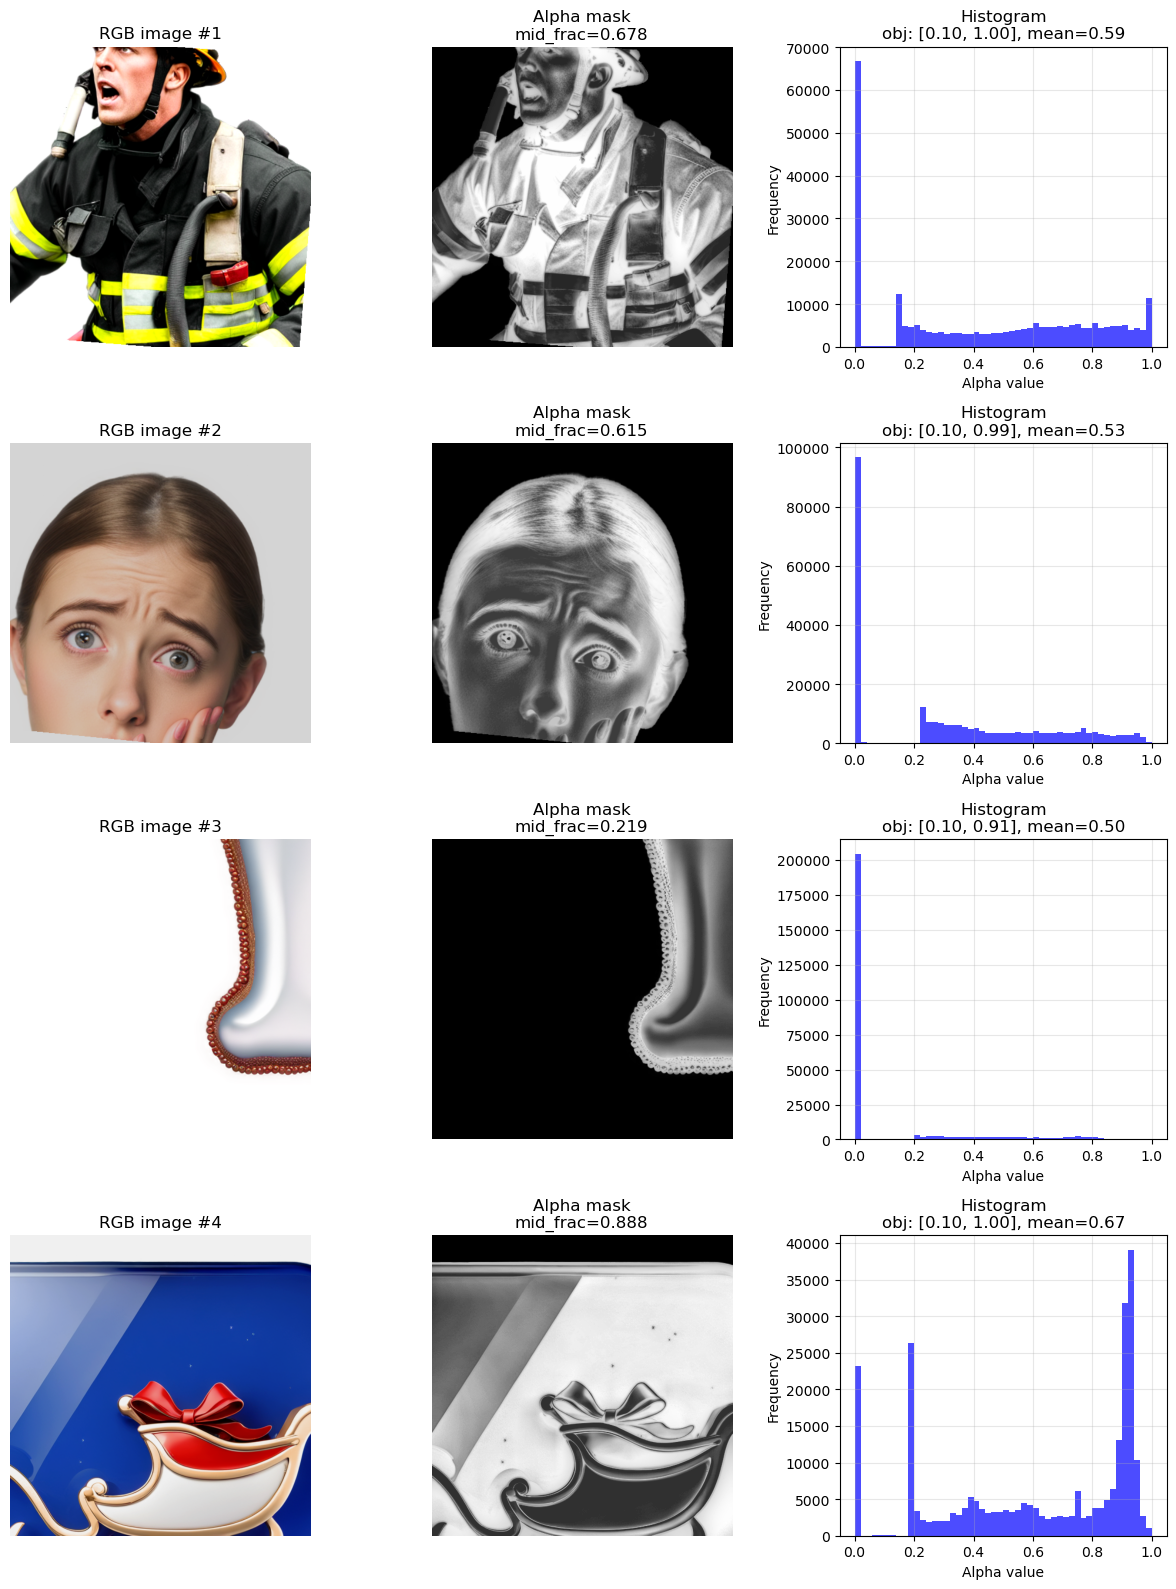


Визуальная проверка:
- Маски должны быть НЕ бинарными (не просто белое/черное)
- Внутри объекта должны быть видны полутона (серые оттенки)
- Гистограмма должна иметь распределение в середине диапазона
- Если маски чисто белые внутри → x-ray аугментация НЕ работает!


In [20]:
import matplotlib.pyplot as plt

# Функция для денормализации изображения
def denorm_img(x):
    """x: [3,H,W] нормализованное -> [H,W,3] в [0,1]"""
    mean = torch.tensor([0.485, 0.456, 0.406], device=x.device, dtype=x.dtype).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=x.device, dtype=x.dtype).view(3, 1, 1)
    x = x * std + mean
    x = x.clamp(0, 1)
    return x.permute(1, 2, 0).cpu().numpy()

# Визуализация примеров из train loader
batch = next(iter(train_loader))
imgs = batch["img"]  # (B, 3, H, W)
masks = batch["mask"]  # (B, 1, H, W)

n_show = min(6, imgs.shape[0])

fig, axes = plt.subplots(n_show, 3, figsize=(12, 4*n_show))
if n_show == 1:
    axes = axes.reshape(1, -1)

for i in range(n_show):
    img = denorm_img(imgs[i])
    mask = masks[i, 0].cpu().numpy()
    
    # Статистика маски
    mid_frac = np.mean((mask > 0.05) & (mask < 0.95))
    obj_pixels = mask[mask > 0.1]
    if len(obj_pixels) > 0:
        obj_min = obj_pixels.min()
        obj_max = obj_pixels.max()
        obj_mean = obj_pixels.mean()
    else:
        obj_min = obj_max = obj_mean = 0.0
    
    # RGB изображение
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"RGB image #{i+1}")
    axes[i, 0].axis("off")
    
    # Alpha маска
    axes[i, 1].imshow(mask, cmap='gray', vmin=0, vmax=1)
    axes[i, 1].set_title(f"Alpha mask\nmid_frac={mid_frac:.3f}")
    axes[i, 1].axis("off")
    
    # Гистограмма маски
    axes[i, 2].hist(mask.flatten(), bins=50, range=(0, 1), color='blue', alpha=0.7)
    axes[i, 2].set_title(f"Histogram\nobj: [{obj_min:.2f}, {obj_max:.2f}], mean={obj_mean:.2f}")
    axes[i, 2].set_xlabel("Alpha value")
    axes[i, 2].set_ylabel("Frequency")
    axes[i, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nВизуальная проверка:")
print("- Маски должны быть НЕ бинарными (не просто белое/черное)")
print("- Внутри объекта должны быть видны полутона (серые оттенки)")
print("- Гистограмма должна иметь распределение в середине диапазона")
print("- Если маски чисто белые внутри → x-ray аугментация НЕ работает!")

In [21]:
def u2net_outputs_to_list(outputs):
    """Преобразует выходы модели в список."""
    if isinstance(outputs, (list, tuple)):
        return list(outputs)
    return [outputs]

def sobel(x):
    """Sobel оператор для вычисления градиентов (краёв)."""
    kx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    ky = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    gx = F.conv2d(x, kx, padding=1)
    gy = F.conv2d(x, ky, padding=1)
    return torch.sqrt(gx*gx + gy*gy + 1e-6)

def sobel_mag(x):
    """Sobel оператор для вычисления магнитуды градиента."""
    kx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    ky = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    xx = x[None,None]
    gx = F.conv2d(xx, kx, padding=1)
    gy = F.conv2d(xx, ky, padding=1)
    return torch.sqrt(gx*gx + gy*gy + 1e-6)[0,0]

def erode(mask01, k=15):
    """Эрозия маски через min pooling."""
    x = mask01[None,None]
    return (-F.max_pool2d(-x, kernel_size=k, stride=1, padding=k//2))[0,0]

def thin_map(alpha01, k=15, thr=0.1):
    """Создаёт карту тонких зон (тонкие детали + края)."""
    obj = (alpha01 > thr).float()
    core = erode(obj, k=k)
    thin = (obj - core).clamp(0,1)
    return thin

def charbonnier(x, eps=1e-3):
    """Charbonnier loss (smooth L1)."""
    return torch.sqrt(x*x + eps*eps)

def u2net_mse_loss(outputs, target):
    """
    Улучшенный loss для U2NETP с фокусом на внутреннюю структуру объекта.
    
    ИСПРАВЛЕНО согласно проблеме 5:
    - Увеличен вес ошибки внутри объекта и на изменениях GT
    - w = 1 + 2*obj + 2*(|∇gt| > t)
    - Убраны/уменьшены "thin/edge loss", чтобы не тащить в контуры
    """
    outs = u2net_outputs_to_list(outputs)
    total_loss = 0.0
    
    for out in outs:
        pred = out
        gt = target
        B, C, H, W = pred.shape
        
        # Weighted MSE с увеличенным весом внутри объекта и на изменениях GT
        # w = 1 + 2*obj + 2*(|∇gt| > t)
        obj = (gt > 0.01).float()  # (B, 1, H, W)
        
        # Вычисляем градиенты GT для каждого элемента батча
        grad_mask_batch = []
        grad_threshold = 0.05  # порог для зон изменений
        
        for b in range(B):
            gt_alpha = gt[b, 0]  # (H, W)
            grad_gt = sobel_mag(gt_alpha)  # (H, W)
            grad_mask = (grad_gt > grad_threshold).float()  # зоны изменений
            grad_mask_batch.append(grad_mask)
        
        # Объединяем маски градиентов в тензор (B, 1, H, W)
        grad_mask_tensor = torch.stack(grad_mask_batch, dim=0)[:, None, :, :]
        
        # Веса: внутри объекта в 3 раза важнее, на изменениях GT в 3 раза важнее
        w = 1.0 + 2.0 * obj + 2.0 * grad_mask_tensor  # (B, 1, H, W)
        
        base = ((pred - gt).pow(2) * w).mean()
        
        # bg-aware: ЖЁСТКИЙ штраф за "туман" на фоне
        bg_mask = (gt <= 0.05).float()
        eps = 0.02
        haze = torch.relu(pred - eps)
        bg_penalty = (haze * haze * bg_mask).sum() / (bg_mask.sum() + 1e-6)
        bg_mse = ((pred * bg_mask).pow(2)).sum() / (bg_mask.sum() + 1e-6)
        bg_loss = bg_mse + 2.0 * bg_penalty
        
        # Итоговый loss:
        # - base (weighted MSE): 1.0 (главный, с увеличенным весом внутри объекта и на изменениях)
        # - bg: 0.5 (важно для чистого фона)
        # Убраны thin/edge loss, чтобы не тащить в контуры
        loss = base + 0.5 * bg_loss
        
        total_loss += loss
    
    return total_loss / len(outs)

@torch.no_grad()
def u2net_mse_metric(outputs, target):
    """Метрика MSE по главному выходу (d0)."""
    out0 = u2net_outputs_to_list(outputs)[0]
    return F.mse_loss(out0, target)

In [22]:
def u2net_outputs_to_list(outputs):
    """Преобразует выходы модели в список."""
    if isinstance(outputs, (list, tuple)):
        return list(outputs)
    return [outputs]

def sobel(x):
    """Sobel оператор для вычисления градиентов (краёв)."""
    kx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    ky = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    gx = F.conv2d(x, kx, padding=1)
    gy = F.conv2d(x, ky, padding=1)
    return torch.sqrt(gx*gx + gy*gy + 1e-6)

def sobel_mag(x):
    """Sobel оператор для вычисления магнитуды градиента."""
    kx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    ky = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    xx = x[None,None]
    gx = F.conv2d(xx, kx, padding=1)
    gy = F.conv2d(xx, ky, padding=1)
    return torch.sqrt(gx*gx + gy*gy + 1e-6)[0,0]

def erode(mask01, k=15):
    """Эрозия маски через min pooling."""
    x = mask01[None,None]
    return (-F.max_pool2d(-x, kernel_size=k, stride=1, padding=k//2))[0,0]

def thin_map(alpha01, k=15, thr=0.1):
    """Создаёт карту тонких зон (тонкие детали + края)."""
    obj = (alpha01 > thr).float()
    core = erode(obj, k=k)
    thin = (obj - core).clamp(0,1)
    return thin

def charbonnier(x, eps=1e-3):
    """Charbonnier loss (smooth L1)."""
    return torch.sqrt(x*x + eps*eps)

def u2net_mse_loss(outputs, target):
    """
    Улучшенный loss для U2NETP с фокусом на внутреннюю структуру объекта.
    
    ИСПРАВЛЕНО: Добавлена детализация внутри объекта через weighted MSE с весом от градиента GT.
    Это стимулирует модель предсказывать сложную структуру внутри объекта, а не только края.
    """
    outs = u2net_outputs_to_list(outputs)
    total_loss = 0.0
    
    for out in outs:
        pred = out
        gt = target
        B, C, H, W = pred.shape
        
        # Базовый MSE loss
        base = F.mse_loss(pred, gt)
        
        # bg-aware: ЖЁСТКИЙ штраф за "туман" на фоне
        bg_mask = (gt <= 0.05).float()
        eps = 0.02
        haze = torch.relu(pred - eps)
        bg_penalty = (haze * haze * bg_mask).sum() / (bg_mask.sum() + 1e-6)
        bg_mse = ((pred * bg_mask).pow(2)).sum() / (bg_mask.sum() + 1e-6)
        bg_loss = bg_mse + 2.0 * bg_penalty
        
        # ИСПРАВЛЕНО: Детализация внутри объекта через weighted MSE
        # Усиливаем MSE там, где у GT есть изменения (градиенты), а не только в тонких зонах
        obj_weighted_mse_total = 0.0
        for b in range(B):
            gt_alpha = gt[b, 0]  # (H, W)
            pred_alpha = pred[b, 0]  # (H, W)
            
            # Маска объекта
            obj = (gt_alpha > 0.1).float()  # (H, W)
            
            # Градиент GT внутри объекта
            grad_gt = sobel_mag(gt_alpha) * obj  # (H, W)
            
            # Weighted MSE: ((pred-gt)^2 * (1 + k*|∇gt|)).mean()
            # k - коэффициент усиления для зон с изменениями
            k = 2.0  # усиление для зон с градиентами
            weight = 1.0 + k * grad_gt  # (H, W)
            
            diff = pred_alpha - gt_alpha  # (H, W)
            obj_weighted_mse = ((diff.pow(2) * weight) * obj).sum() / (obj.sum() + 1e-6)
            obj_weighted_mse_total += obj_weighted_mse
        
        obj_weighted_mse_loss = obj_weighted_mse_total / B
        
        # edge-aware: совпадение градиентов (границы) - оставляем, но с меньшим весом
        edge_loss = (sobel(pred) - sobel(gt)).abs().mean()
        
        # Итоговый loss:
        # - base MSE: 1.0 (главный)
        # - obj_weighted_mse: 0.8 (детализация внутри объекта - НОВОЕ!)
        # - edge: 0.1 (границы - уменьшен вес, т.к. obj_weighted_mse уже покрывает)
        # - bg: 0.5 (важно для чистого фона)
        loss = base + 0.8 * obj_weighted_mse_loss + 0.1 * edge_loss + 0.5 * bg_loss
        
        total_loss += loss
    
    return total_loss / len(outs)

@torch.no_grad()
def u2net_mse_metric(outputs, target):
    """Метрика MSE по главному выходу (d0)."""
    out0 = u2net_outputs_to_list(outputs)[0]
    return F.mse_loss(out0, target)

## 4. Model Init

In [23]:
u2net_path = Path("U-2-Net")
if str(u2net_path.absolute()) not in sys.path:
    sys.path.insert(0, str(u2net_path.absolute()))

from model.u2net import U2NETP  

model = U2NETP(in_ch=3, out_ch=1).to(device)

ckpt_path = Path("U-2-Net/saved_models/u2netp/u2netp.pth")
ckpt = torch.load(ckpt_path, map_location="cpu")
state = ckpt if isinstance(ckpt, dict) and "state_dict" not in ckpt else ckpt.get("state_dict", ckpt)
model.load_state_dict(state, strict=True)

<All keys matched successfully>

## 5. Loss

In [24]:
def u2net_outputs_to_list(outputs):
    """Преобразует выходы модели в список."""
    if isinstance(outputs, (list, tuple)):
        return list(outputs)
    return [outputs]

def sobel(x):
    """Sobel оператор для вычисления градиентов (краёв)."""
    kx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    ky = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    gx = F.conv2d(x, kx, padding=1)
    gy = F.conv2d(x, ky, padding=1)
    return torch.sqrt(gx*gx + gy*gy + 1e-6)

def sobel_mag(x):
    """Sobel оператор для вычисления магнитуды градиента."""
    kx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    ky = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    xx = x[None,None]
    gx = F.conv2d(xx, kx, padding=1)
    gy = F.conv2d(xx, ky, padding=1)
    return torch.sqrt(gx*gx + gy*gy + 1e-6)[0,0]

def erode(mask01, k=15):
    """Эрозия маски через min pooling."""
    x = mask01[None,None]
    return (-F.max_pool2d(-x, kernel_size=k, stride=1, padding=k//2))[0,0]

def thin_map(alpha01, k=15, thr=0.1):
    """Создаёт карту тонких зон (тонкие детали + края)."""
    obj = (alpha01 > thr).float()
    core = erode(obj, k=k)
    thin = (obj - core).clamp(0,1)
    return thin

def charbonnier(x, eps=1e-3):
    """Charbonnier loss (smooth L1)."""
    return torch.sqrt(x*x + eps*eps)

def u2net_mse_loss(outputs, target):
    """Улучшенный loss для U2NETP с защитой тонких деталей и чистым фоном."""
    outs = u2net_outputs_to_list(outputs)
    total_loss = 0.0
    
    for out in outs:
        pred = out
        gt = target
        B, C, H, W = pred.shape
        
        base = F.mse_loss(pred, gt)
        
        # bg-aware: ЖЁСТКИЙ штраф за "туман" на фоне
        bg_mask = (gt <= 0.05).float()
        eps = 0.02
        haze = torch.relu(pred - eps)
        bg_penalty = (haze * haze * bg_mask).sum() / (bg_mask.sum() + 1e-6)
        bg_mse = ((pred * bg_mask).pow(2)).sum() / (bg_mask.sum() + 1e-6)
        bg_loss = bg_mse + 2.0 * bg_penalty
        
        # edge-aware: совпадение градиентов
        edge_loss = (sobel(pred) - sobel(gt)).abs().mean()
        
        # thin-aware: weighted loss для тонких частей
        thin_loss_total = 0.0
        for b in range(B):
            gt_alpha = gt[b, 0]
            pred_alpha = pred[b, 0]
            thin = thin_map(gt_alpha, k=21, thr=0.1)
            w = 1.0 + 4.0 * thin
            diff = pred_alpha - gt_alpha
            thin_mse = (w * diff.pow(2)).mean()
            thin_charb = (w * charbonnier(diff)).mean()
            thin_loss_total += thin_mse + 0.3 * thin_charb
        thin_loss = thin_loss_total / B
        
        # gradient-aware: loss на градиенты внутри объекта
        gradient_loss_total = 0.0
        for b in range(B):
            gt_alpha = gt[b, 0]
            pred_alpha = pred[b, 0]
            obj = (gt_alpha > 0.1).float()
            gp = sobel_mag(pred_alpha) * obj
            gg = sobel_mag(gt_alpha) * obj
            gradient_loss_total += (gp - gg).abs().mean()
        gradient_loss = gradient_loss_total / B
        
        loss = base + 0.2 * edge_loss + 0.5 * bg_loss + 0.5 * thin_loss + 0.2 * gradient_loss
        total_loss += loss
    
    return total_loss / len(outs)

@torch.no_grad()
def u2net_mse_metric(outputs, target):
    """Метрика MSE по главному выходу (d0)."""
    out0 = u2net_outputs_to_list(outputs)[0]
    return F.mse_loss(out0, target)

## 6. Train Loop

In [25]:
USE_AMP = False
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0
    total_mse = 0.0

    for batch in tqdm(loader, desc="train", leave=False, total=len(loader)):
        imgs = batch["img"].to(device, non_blocking=True)
        masks = batch["mask"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=USE_AMP):
            outputs = model(imgs)
            loss = u2net_mse_loss(outputs, masks)

        if not torch.isfinite(loss):
            print("[WARN] Non-finite loss в train_epoch. Прерываем обучение.")
            raise RuntimeError("Non-finite loss")

        if USE_AMP:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        bs = imgs.size(0)
        total_loss += float(loss.detach().item()) * bs
        total_mse += float(u2net_mse_metric(outputs, masks).item()) * bs

    n = len(loader.dataset)
    return total_loss / n, total_mse / n


@torch.no_grad()
def eval_epoch(model, loader):
    """Стандартная валидация: считает loss/metric на выходах модели."""
    model.eval()
    total_loss = 0.0
    total_mse = 0.0

    for batch in tqdm(loader, desc="val", leave=False):
        imgs = batch["img"].to(device, non_blocking=True)
        masks = batch["mask"].to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=USE_AMP):
            outputs = model(imgs)
            loss = u2net_mse_loss(outputs, masks)

        if not torch.isfinite(loss):
            print("[WARN] Non-finite loss в eval_epoch. Прерываем валидацию.")
            raise RuntimeError("Non-finite loss")

        bs = imgs.size(0)
        total_loss += float(loss.item()) * bs
        total_mse += float(u2net_mse_metric(outputs, masks).item()) * bs

    n = len(loader.dataset)
    return total_loss / n, total_mse / n

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

# Оптимизатор AdamW с weight decay для регуляризации
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

# Scheduler: уменьшает learning rate при отсутствии улучшения
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2, verbose=True
)

# Функция для получения уникального имени файла с номером
def get_unique_path(base_path):
    """Если файл существует, добавляет номер (2, 3, ...) к имени"""
    if not base_path.exists():
        return base_path
    
    base_dir = base_path.parent
    base_name = base_path.stem
    base_ext = base_path.suffix
    
    counter = 2
    while True:
        new_path = base_dir / f"{base_name}_{counter}{base_ext}"
        if not new_path.exists():
            return new_path
        counter += 1

best_val_mse = float("inf")
best_path_base = MODEL_DIR / "u2netp_best.pth"
best_path = get_unique_path(best_path_base)  # Получаем уникальное имя при первом сохранении

if RUN_TRAINING:
    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss, train_mse = train_epoch(model, train_loader, optimizer)
        
        # Стандартная валидация (на выходах модели)
        val_loss, val_mse = eval_epoch(model, val_loader)
        
        # Обновляем learning rate на основе val_mse
        scheduler.step(val_mse)
        current_lr = optimizer.param_groups[0]["lr"]
        
        print(f"Epoch {epoch}: train_mse={train_mse:.6f} val_mse={val_mse:.6f} lr={current_lr:.2e}")

        # Сохраняем лучшую модель по стандартной val_mse
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            # Если это первое сохранение, используем уже полученное уникальное имя
            # Если файл был удалён/перемещён, получаем новое уникальное имя
            if not best_path.exists() and best_path != best_path_base:
                best_path = get_unique_path(best_path_base)
            torch.save({"model_state": model.state_dict()}, best_path)
            print(f"  -> Сохранена лучшая модель: {best_path.name} (val_mse={best_val_mse:.6f})")
else:
    # При загрузке ищем последнюю сохранённую модель (с наибольшим номером)
    best_path_to_load = best_path_base
    if best_path_to_load.exists():
        # Базовая модель существует
        pass
    else:
        # Ищем модель с наибольшим номером
        max_counter = 0
        counter = 2
        while True:
            candidate = MODEL_DIR / f"u2netp_best_{counter}.pth"
            if candidate.exists():
                max_counter = counter
                counter += 1
            else:
                break
        
        if max_counter > 0:
            best_path_to_load = MODEL_DIR / f"u2netp_best_{max_counter}.pth"
    
    if best_path_to_load.exists():
        print(f"Загружаем модель: {best_path_to_load.name}")
        model.load_state_dict(torch.load(best_path_to_load, map_location=device)["model_state"])
    else:
        print(f"Модель не найдена в {MODEL_DIR}")

c:\Users\79104\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


train:   0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\79104\anaconda3\Lib\site-packages\torch\nn\functional.py:3809: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


## 7. Infer + Submission

In [ ]:
model.eval()

test_dataset = TestImageDataset(TEST_ROOT)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

rows = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="test", leave=False):
        imgs = batch["img"].to(device)
        names = batch["path"]
        
        # Flip-TTA: усреднение pred(x) и pred(flip(x))
        outputs = model(imgs)
        out0 = outputs[0] if isinstance(outputs, (list, tuple)) else outputs
        probs_orig = out0
        
        imgs_flip = torch.flip(imgs, dims=[3])
        outputs_flip = model(imgs_flip)
        out0_flip = outputs_flip[0] if isinstance(outputs_flip, (list, tuple)) else outputs_flip
        probs_flip = torch.flip(out0_flip, dims=[3])
        
        probs = (probs_orig + probs_flip) / 2.0
        
        pred = probs[0, 0]  # [H, W] в диапазоне [0, 1]
        
        # ИСПРАВЛЕНО: Компонентный постпроцесс с мягкими критериями
        pred_np = pred.cpu().numpy()
        supp = (pred_np > 0.05).astype(np.uint8)  # поддержка (низкий порог для захвата всех объектов)
        
        # Находим компоненты связности
        lab, n = scipy.ndimage.label(supp)
        
        keep = np.zeros_like(supp, dtype=np.uint8)
        scores = []
        H, W = pred_np.shape
        total_pixels = H * W
        
        for k in range(1, n + 1):
            m = (lab == k)
            max_conf = pred_np[m].max()  # максимальная уверенность в компоненте
            area = m.sum()  # площадь компонента
            area_frac = area / total_pixels  # доля от общего размера изображения
            
            scores.append((max_conf, area, area_frac, k))
        
        # Сортируем по max confidence (приоритет), затем по площади
        scores.sort(key=lambda x: (x[0], x[1]), reverse=True)
        
        # Оставляем top-3 компонентов с мягкими критериями:
        # 1. max_conf > 0.20 (снижен с 0.35) - для захвата маленьких объектов
        # 2. ИЛИ area_frac > 0.01 (1% от изображения) - большие компоненты оставляем даже при меньшей уверенности
        for max_conf, area, area_frac, k in scores[:3]:
            if max_conf > 0.20 or area_frac > 0.01:
                keep[lab == k] = 1
        
        # Конвертируем маску поддержки в torch
        keep_torch = torch.from_numpy(keep).float().to(pred.device)
        
        # ИСПРАВЛЕНО: Дилатация только для маски поддержки, а не для предикта
        # Это сохраняет детали в предикте, но расширяет область поддержки для мягких краёв
        if keep.sum() > 0:
            keep_dilated = F.max_pool2d(
                keep_torch[None, None], 
                kernel_size=7, 
                stride=1, 
                padding=3
            )[0, 0]
            # Применяем дилатированную маску к предикту (не размываем сам предикт!)
            pred = pred * keep_dilated
        else:
            # Если нет компонентов, просто применяем исходную маску
            pred = pred * keep_torch
        
        # Конвертация в numpy для сохранения
        pred_np = pred.cpu().numpy()
        mask = (pred_np * 255).astype(np.uint8)
        
        pil_mask = Image.fromarray(mask, mode="L")
        buf = io.BytesIO()
        pil_mask.save(buf, format="PNG")
        image_utf = base64.b64encode(buf.getvalue()).decode("utf-8")
        rows.append({"filename": names[0].split(".")[0], "image_utf": image_utf})

submission = pd.DataFrame(rows)

submission_path = MODEL_DIR / "submission.csv"
submission_path = get_unique_path(submission_path)
submission.to_csv(submission_path, index=False)
print(f"Saved submission to {submission_path}")

test:   0%|          | 0/100 [00:00<?, ?it/s]

Saved submission to outputs\experiments\exp_001\submission_20.csv


Загружено строк: 100
Колонки: ['filename', 'image_utf']
Первые 3 filename: [1, 2, 3]

[1] 1: shape=(1024, 1024), dtype=uint8, min=0, max=251

[2] 2: shape=(1024, 1024), dtype=uint8, min=0, max=248

[3] 3: shape=(1024, 1024), dtype=uint8, min=0, max=253


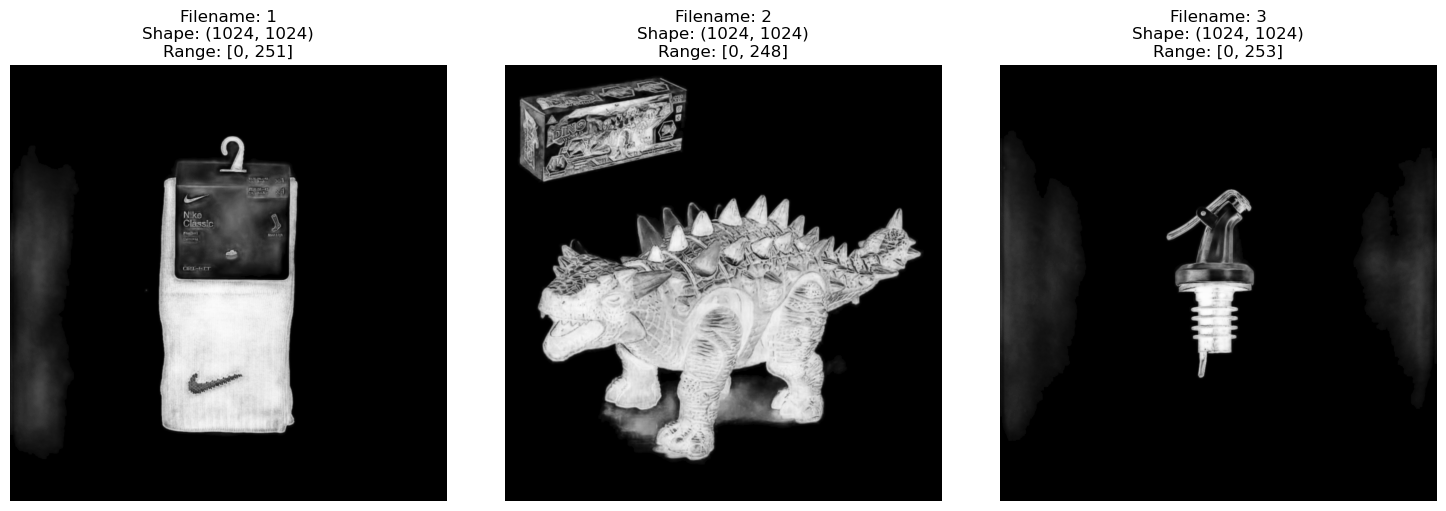


Успешно декодировано и визуализировано 3 изображений из submission.csv


In [ ]:
# Визуализация submission.csv - декодирование и отображение предсказанных масок
import base64
import io
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

# Путь к submission файлу
submission_path = Path("outputs/experiments/exp_001/submission_20.csv")
#submission_path = Path("data/example_submission.csv")

if not submission_path.exists():
    print(f"Файл не найден: {submission_path}")
else:
    df = pd.read_csv(submission_path)
    print(f"Загружено строк: {len(df)}")
    print(f"Колонки: {df.columns.tolist()}")
    print(f"Первые 3 filename: {df.head(3)['filename'].tolist()}")

    def decode_png(b64):
        """Декодирует base64 строку в PIL Image"""
        data = base64.b64decode(b64)
        im = Image.open(io.BytesIO(data))
        im.load()
        return im

    # Визуализация первых N изображений
    n_show = min(3, len(df))
    fig, axes = plt.subplots(1, n_show, figsize=(5 * n_show, 5))
    
    if n_show == 1:
        axes = [axes]
    
    for i in range(n_show):
        fn = df.loc[i, "filename"]
        b64 = df.loc[i, "image_utf"]
        
        try:
            im = decode_png(b64)
            arr = np.array(im)
            
            axes[i].imshow(arr, cmap="gray", vmin=0, vmax=255)
            axes[i].set_title(f"Filename: {fn}\nShape: {arr.shape}\nRange: [{arr.min()}, {arr.max()}]")
            axes[i].axis("off")
            
            print(f"\n[{i+1}] {fn}: shape={arr.shape}, dtype={arr.dtype}, min={arr.min()}, max={arr.max()}")
        except Exception as e:
            print(f"Ошибка при декодировании {fn}: {e}")
            axes[i].text(0.5, 0.5, f"Error:\n{str(e)}", ha="center", va="center")
            axes[i].axis("off")
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nУспешно декодировано и визуализировано {n_show} изображений из submission.csv")

